In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
from matplotlib import pylab as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size
plt.rc("animation", html="html5")


In [2]:
import pandas as pd
import numpy as np
from time import sleep
from pprint import pprint

In [3]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

## Run a session of the SCML world (2021)

The SCML world (Supply Chain Management League) runs on top of `NegMAS`.

In this tutorial, you will test a run of this world.

Firstly, let's import everything from the SCML app

**Note that the 2021 standard and collusion leagues are almost the same as 2020 versions with minor changes in the configuration and available data to the agent which will be explained later**. All agents developed for SCML2020 run with no modification in SCML2021's standard and collusion leagues. Moreover, agents devleoped for SCML-OneShot run normally in SCML2021 worlds.

In [4]:
from scml.scml2020 import *
from scml.oneshot import *

There are several ways to create an SCML world. One of the simplest is to use the `generate` method of the `SCML2021World` class. This will create a dict that can be passed to the `SCML2021World` constructor as keyword arguments. 

Here we explicitly set `construct_graphs` to True which slows the simulation yet allows us to see graph representations of what is happening in the world. 


In [5]:
agent_types = [DecentralizingAgent, BuyCheapSellExpensiveAgent, 
               MarketAwareDecentralizingAgent, MarketAwareIndDecentralizingAgent,
               IndDecentralizingAgent, MovingRangeAgent, SyncRandomOneShotAgent]

Notice that we have a one-shot agent in the mix. Even though one-shot agents are designed for `SCML2020OneShot` worlds, they can run with no modification in `SCML2020` and `SCML2021` worlds.

In [6]:
world = SCML2021World(
    **SCML2021World.generate(
        agent_types=agent_types,
        n_steps=50
    ), 
    construct_graphs=True,
)

Let's draw a graph to see what is in this world

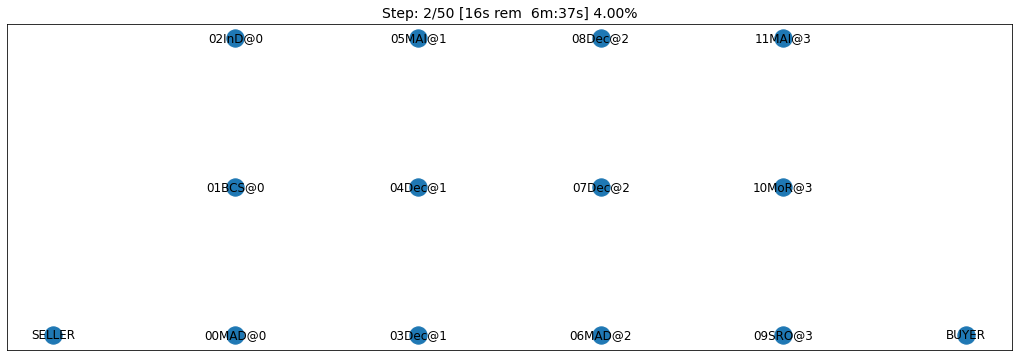

In [7]:
_, _ = world.draw()

*If you want to just test your installation (and do not care whether you get an accurate indicator of agent performance), you can set the number of steps to a small value (e.g. n_steps=10).*

Now you can run this world simulation by just calling `run`. 

In [8]:
world.run_with_progress() # may take few minutes


100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


Let's see what happened in this run. Firstly, how many negotiations were conducted over time

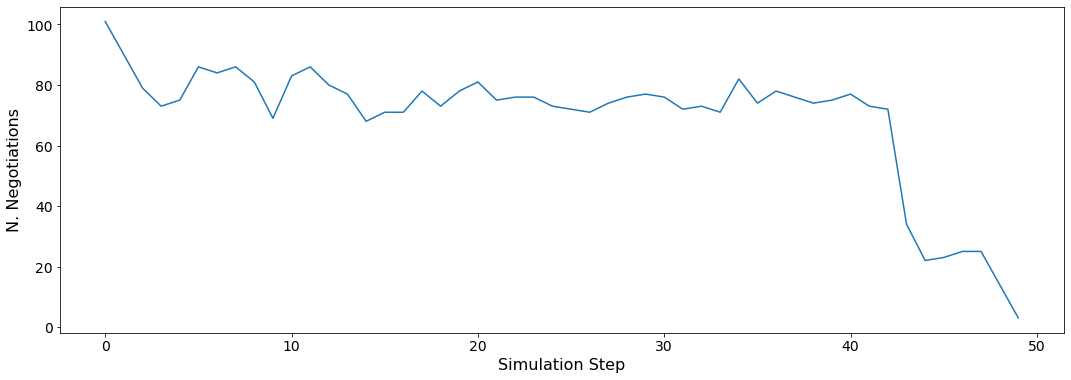

In [9]:
plt.plot(world.stats['n_negotiations'])
plt.xlabel('Simulation Step')
plt.ylabel('N. Negotiations')
plt.show()

It is clear that many negotiations happened at the beginning of the simulation with smaller number later. That is expected as the agents at the first and last production layer receive more exogenous contracts in the beginning.

Several other market statistics are available:

In [10]:
pprint(list(_ for _ in world.stats.keys() if "@" not in _  ))

['n_contracts_nullified_now',
 'n_bankrupt',
 'trading_price_0',
 'sold_quantity_0',
 'unit_price_0',
 'trading_price_1',
 'sold_quantity_1',
 'unit_price_1',
 'trading_price_2',
 'sold_quantity_2',
 'unit_price_2',
 'trading_price_3',
 'sold_quantity_3',
 'unit_price_3',
 'trading_price_4',
 'sold_quantity_4',
 'unit_price_4',
 'productivity',
 'market_size',
 'production_failures',
 'bankruptcy',
 'n_registered_negotiations_before',
 'n_contracts_executed',
 'n_contracts_erred',
 'n_contracts_nullified',
 'n_contracts_cancelled',
 'n_contracts_dropped',
 'n_breaches',
 'breach_level',
 'n_contracts_signed',
 'n_contracts_concluded',
 'n_negotiations',
 'n_negotiation_rounds_successful',
 'n_negotiation_rounds_failed',
 'n_negotiation_successful',
 'n_negotiation_failed',
 'n_registered_negotiations_after',
 'activity_level',
 'step_time',
 'total_time']


Let's start by seeing how long did each step take (note that `stats` access the stats as a Dict[str, List] but `stats_df` access the same data as a pandas dataframe.

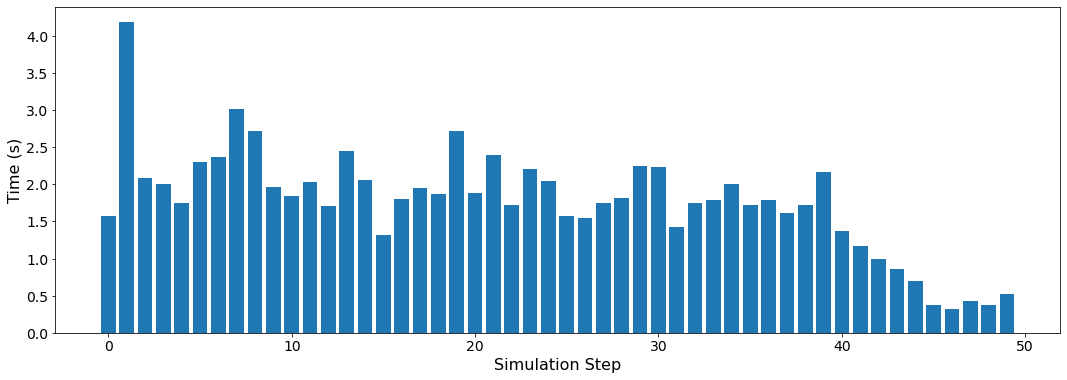

In [11]:
plt.bar(range(world.n_steps), world.stats_df['step_time'])
plt.xlabel('Simulation Step')
plt.ylabel('Time (s)')
plt.show()

There are statistics specific for each agent that all have "_{agent_name}". Lets check what is available for the winner agent:

In [12]:
winner = world.winners[0]
pprint(list(_ for _ in world.stats.keys() if winner.name in _ ))

['spot_market_quantity_05MAI@1',
 'spot_market_loss_05MAI@1',
 'balance_05MAI@1',
 'inventory_05MAI@1_input',
 'inventory_05MAI@1_output',
 'productivity_05MAI@1',
 'assets_05MAI@1',
 'bankrupt_05MAI@1',
 'score_05MAI@1']


The convension is that agent names has the form {ind}{Type}{process} where **ind** is a unique index, **Type** is a shortened version of the agent's type name, and **process** is the process the agnet can run. Note that the agent's input product has the same number as its process and its output product has the next number (i.e. an agent that runs process 1, has input product 1 and output product 2).

We can see that 8 pieces of information are available (for each time-step of the simulation):

- **bankrupt** If true, the agent is bankrupt.
- **balance** The money the agent has in its wallet (account).
- **inventory (input)** The number of units of the agent's input product available in its inventory (by the end of the simulation step).
- **inventory (output)** The number of units of the agent's output product available in its inventory (by the end of the simulation step).
- **assets** The value of the agent's assets (input and output products in inventory) evaluated at the trading price
- **spot market quantity** The quantity bought by this agent from the spot market (of its output product on this step). This can only happen as a result of a product-breach.
- **spot market loss** The spot market price for the agent. This value will go up the more the agent buys from the spot market and will be used to calculate the price for this agent at future steps. This way agents that depend on the spot market instead of negotiation get punished.
- **productivity** The fraction of the agent's production lines that were active at a given time-step.
- **score** The score of the agent according to the evaluation rule of ANAC SCML 2020

Let's see how did our agent do

In [13]:
#show the first and last value of each of the agent statistics
pprint({k:(v[0], v[-1]) for k, v in world.stats.items() if winner.name in k })

{'assets_05MAI@1': (0.0, 2793.0),
 'balance_05MAI@1': (16331, 15977),
 'bankrupt_05MAI@1': (False, False),
 'inventory_05MAI@1_input': (0, 0),
 'inventory_05MAI@1_output': (0, 133),
 'productivity_05MAI@1': (0.0, 0.0),
 'score_05MAI@1': (1.0, 1.0040098225254546),
 'spot_market_loss_05MAI@1': (0.3, 0.3),
 'spot_market_quantity_05MAI@1': (0, 0)}


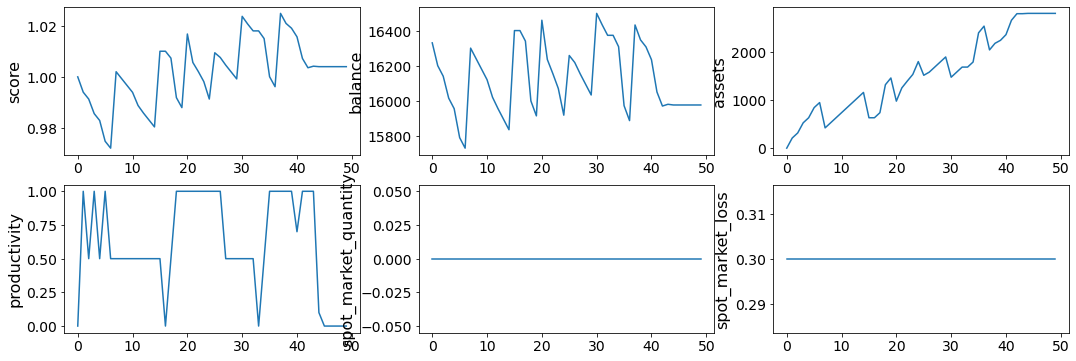

In [14]:
stats = pd.DataFrame(data=world.stats)
fig, axs = plt.subplots(2, 3)
for ax, key in zip(axs.flatten().tolist(), ["score", "balance", "assets", "productivity", 
                         "spot_market_quantity", "spot_market_loss"]):
    ax.plot(stats[f"{key}_{winner}"])
    ax.set(ylabel=key)
fig.show()

We can for example check the activity level of this world (defined as the total amount of money transferred due to trade)

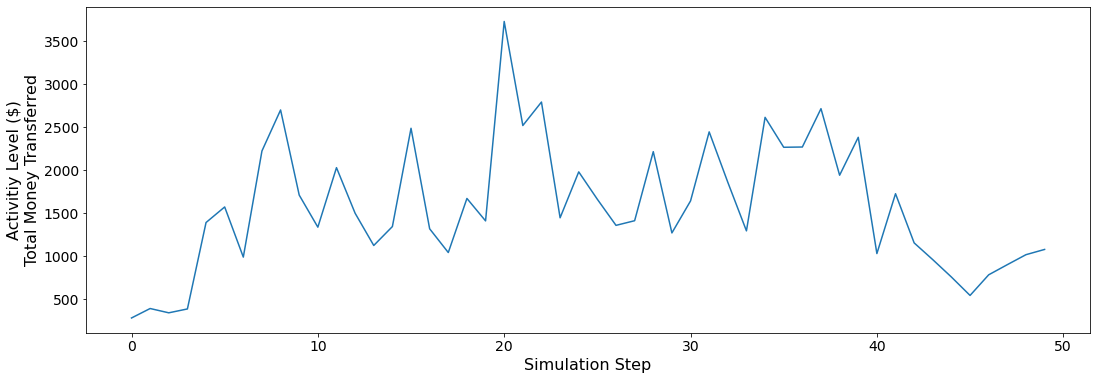

In [15]:
plt.plot(world.stats['activity_level'])
plt.xlabel('Simulation Step')
plt.ylabel('Activitiy Level ($)\nTotal Money Transferred')
plt.show()

We can see a picture of contracting in this world as follows:

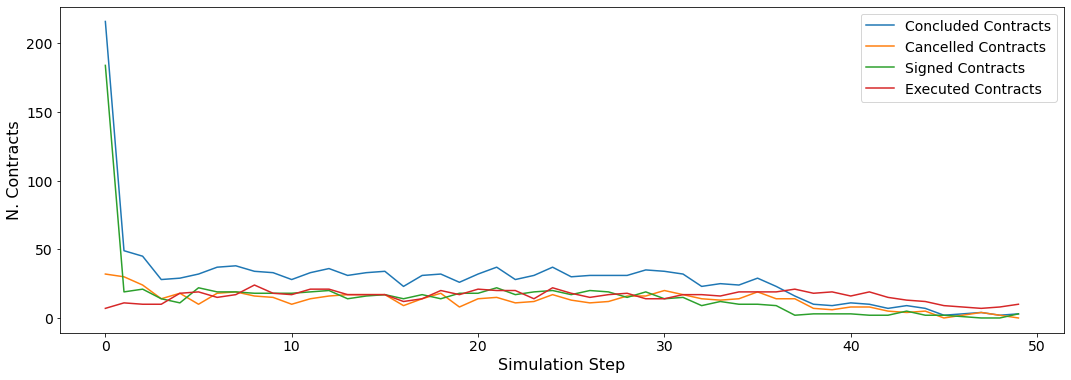

In [16]:
plt.plot(world.stats['n_contracts_concluded'], label='Concluded Contracts')
plt.plot(world.stats['n_contracts_cancelled'], label='Cancelled Contracts') 
plt.plot(world.stats['n_contracts_signed'], label='Signed Contracts') 
plt.plot(world.stats['n_contracts_executed'], label='Executed Contracts')
plt.legend()
plt.xlabel('Simulation Step')
plt.ylabel('N. Contracts')
plt.show()

We can also check the breaches that happened

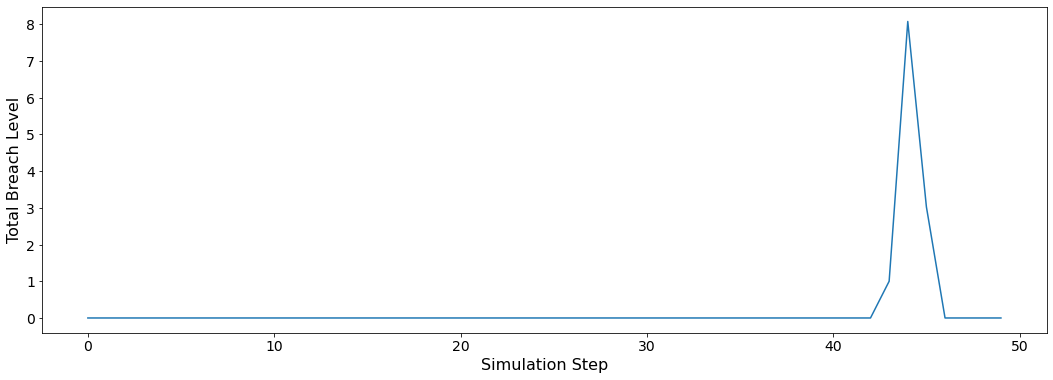

In [17]:
plt.plot(world.stats['breach_level'])
plt.xlabel('Simulation Step')
plt.ylabel('Total Breach Level')
plt.show()

Notice that there can be multiple winners

In [18]:
winner_profits = [100 * world.scores()[_.id] for _ in world.winners]
winner_types = [_.short_type_name for _ in world.winners]
print(f"{world.winners} of type {winner_types} won at {winner_profits}%")

[05MAI@1] of type ['marketawareinddecentralizing'] won at [100.40098225254546]%


Let's check how did the first winner's inventory changes over time:

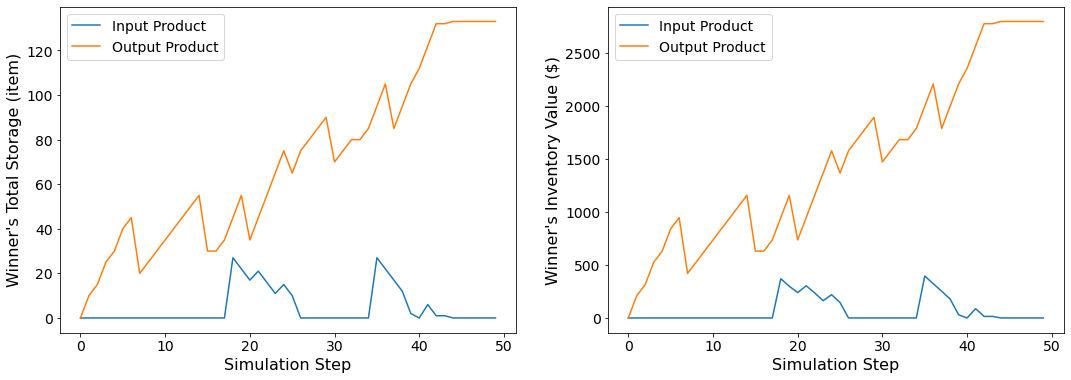

In [19]:
# find the keys in stats for the input and output inventory
in_key = [_ for _ in world.stats.keys() if _.startswith(f'inventory_{winner}_input')][0]
out_key = [_ for _ in world.stats.keys() if _.startswith(f'inventory_{winner}_output')][0]

# find input and output product indices
input_product, output_product = winner.awi.my_input_product, winner.awi.my_output_product
# draw
fig, (quantity, value) = plt.subplots(1, 2)
quantity.plot(world.stats[in_key], label=f"Input Product")
quantity.plot(world.stats[out_key], label=f"Output Product")
quantity.set(xlabel='Simulation Step', ylabel='Winner\'s Total Storage (item)')
quantity.legend()
value.plot(np.array(world.stats[in_key]) * np.array(world.stats[f"trading_price_{input_product}"])
              , label=f"Input Product")
value.plot(np.array(world.stats[out_key]) * np.array(world.stats[f"trading_price_{output_product}"])
              , label=f"Output Product")
value.set(xlabel='Simulation Step', ylabel='Winner\'s Inventory Value ($)')
value.legend()
fig.show()

We can actually check what happens to ALL competitors:

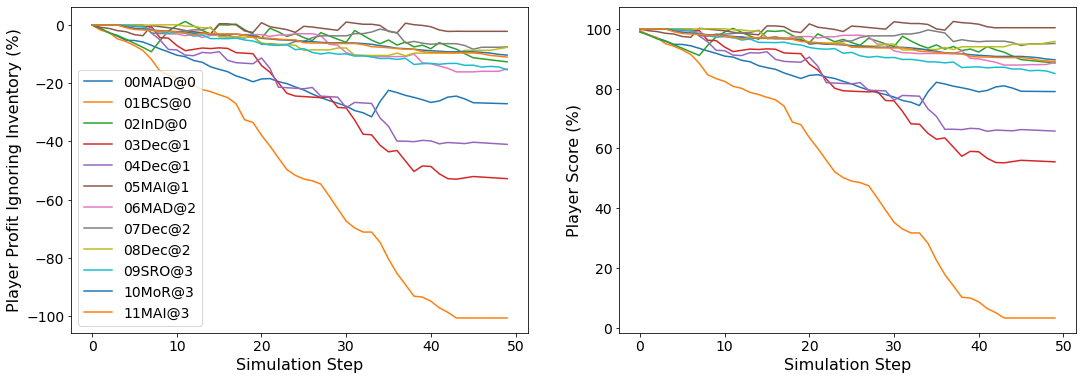

In [20]:
from scml.scml2020.world import is_system_agent
fig, (profit, score) = plt.subplots(1, 2)
snames = sorted(world.non_system_agent_names)
for name in snames:    
    profit.plot(100.0 * (np.asarray(world.stats[f'balance_{name}'])/world.stats[f'balance_{name}'][0] - 1.0), label=name)
    score.plot(100 * np.asarray(world.stats[f'score_{name}']), label=name)
profit.set(xlabel='Simulation Step', ylabel='Player Profit Ignoring Inventory (%)')
profit.legend(loc='lower left')
score.set(xlabel='Simulation Step', ylabel='Player Score (%)')
fig.show()

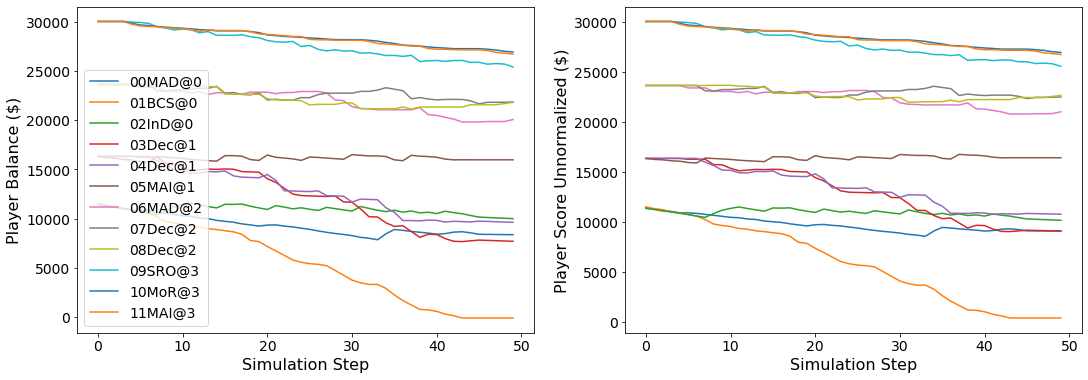

In [21]:
from scml.scml2020.world import is_system_agent
fig, (profit, score) = plt.subplots(1, 2)
snames = sorted(world.non_system_agent_names)
for name in snames:    
    profit.plot((np.asarray(world.stats[f'balance_{name}'])), label=name)
    score.plot(np.asarray(world.stats[f'score_{name}'])*(world.stats[f'balance_{name}'][0]), label=name)
profit.set(xlabel='Simulation Step', ylabel='Player Balance ($)')
profit.legend(loc='lower left')
score.set(xlabel='Simulation Step', ylabel='Player Score Unnormalized ($)')
fig.show()

or just look at the end of the game

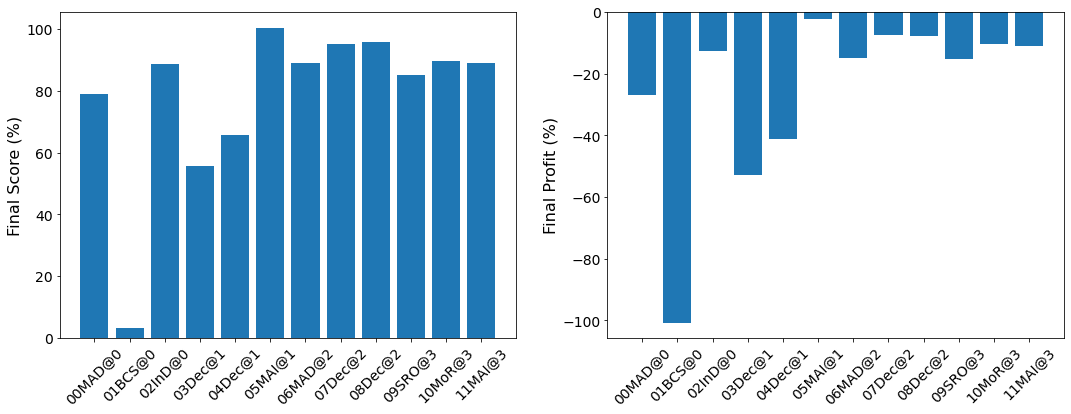

In [22]:
fig, (score, profit) = plt.subplots(1, 2)
final_scores = [100 * world.stats[f"score_{_}"][-1] 
                for _ in world.non_system_agent_names]
final_profits = [100 * world.stats[f"balance_{_}"][-1] / world.stats[f"balance_{_}"][0] - 100 
                 for _ in world.non_system_agent_names]
plt.setp(score.xaxis.get_majorticklabels(), rotation=45)
plt.setp(profit.xaxis.get_majorticklabels(), rotation=45)
score.bar(world.non_system_agent_names, final_scores)
profit.bar(world.non_system_agent_names, final_profits)
score.set(ylabel="Final Score (%)")
profit.set(ylabel="Final Profit (%)")

fig.show()

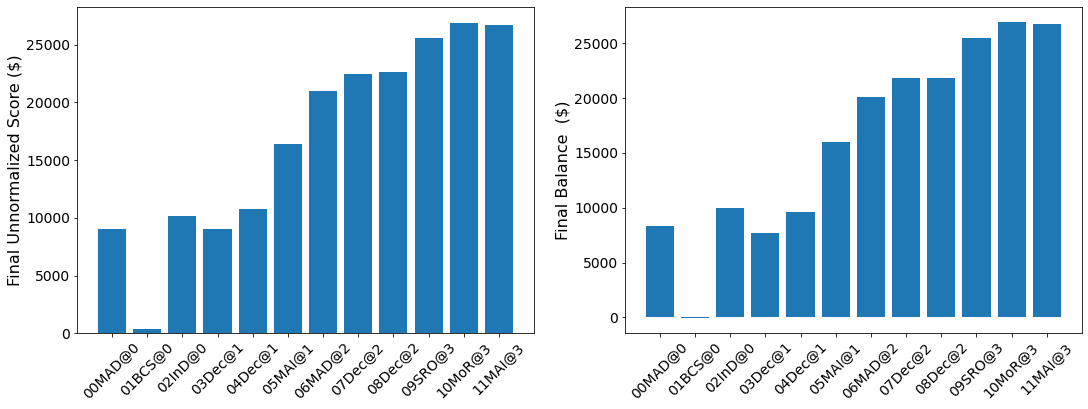

In [23]:
fig, (score, profit) = plt.subplots(1, 2)
final_scores = [world.stats[f"score_{_}"][-1] * (world.stats[f"balance_{_}"][0]) 
                for _ in world.non_system_agent_names]
final_profits = [world.stats[f"balance_{_}"][-1] 
                 for _ in world.non_system_agent_names]
plt.setp(score.xaxis.get_majorticklabels(), rotation=45)
plt.setp(profit.xaxis.get_majorticklabels(), rotation=45)
score.bar(world.non_system_agent_names, final_scores)
profit.bar(world.non_system_agent_names, final_profits)
score.set(ylabel="Final Unnormalized Score ($)")
profit.set(ylabel="Final Balance  ($)")

fig.show()

You can inspect what happened in the simulation by plotting different output statistics. For example, we can see how did the trading price of different products change over the simulation time.

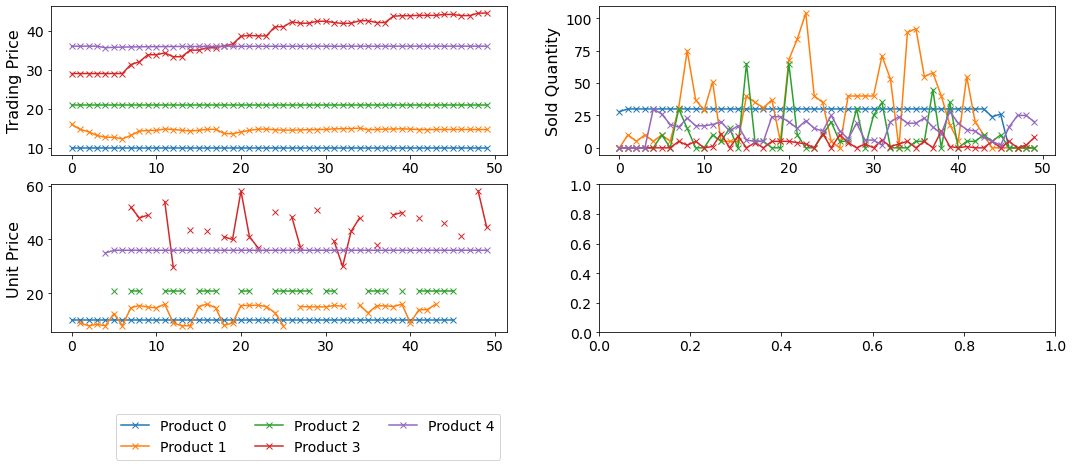

In [24]:
fig, axs = plt.subplots(2, 2)
for ax, key in zip(axs.flatten().tolist(), ["trading_price", "sold_quantity", "unit_price"]):
    for p in range(world.n_products):
        ax.plot(world.stats[f"{key}_{p}"], marker="x", label=f"Product {p}")
        ax.set_ylabel(key.replace("_", " ").title())
        ax.legend().set_visible(False)
axs[-1, 0].legend(bbox_to_anchor=(1, -.5), ncol=3)
fig.show()

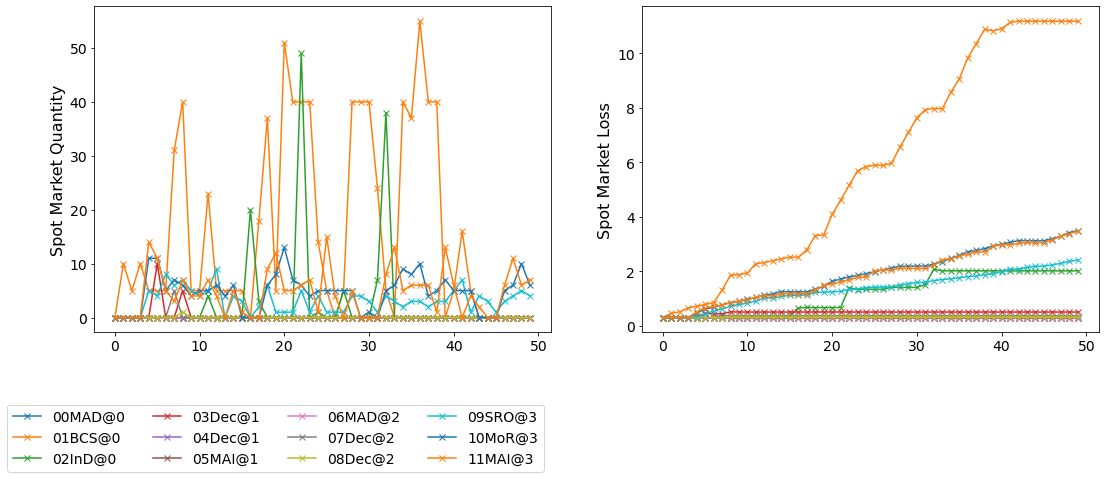

In [25]:
fig, axs = plt.subplots(1, 2)
for ax, key in zip(axs.flatten().tolist(), ["spot_market_quantity", "spot_market_loss"]):
    for a in world.non_system_agent_names:
        ax.plot(world.stats[f"{key}_{a}"], marker="x", label=f"{a}")
        ax.set_ylabel(key.replace("_", " ").title())
        ax.legend().set_visible(False)
axs[0].legend(bbox_to_anchor=(1, -.2), ncol=4)
fig.show()

You can dig futher to understand what happened during this siumulation. For example, let's see some of the contracts that were signed:

In [26]:
# create a view with only signed contracts
contracts = world.contracts_df
signed = contracts.loc[contracts.signed_at>=0, :]

In [27]:
fields = ["seller_name", "buyer_name", "delivery_time", "quantity", "unit_price",
          "signed_at", "executed", "breached", "nullified", "erred"]
signed[fields].sort_values(["quantity", "unit_price"], ascending=False).head(10)

,seller_name,buyer_name,delivery_time,quantity,unit_price,signed_at,executed,breached,nullified,erred
616,02InD@0,04Dec@1,22,64,16,12,True,False,False,False
1084,01BCS@0,04Dec@1,36,50,16,27,True,False,False,False
993,00MAD@0,04Dec@1,34,49,16,24,True,False,False,False
924,02InD@0,03Dec@1,32,48,16,22,True,False,False,False
955,02InD@0,03Dec@1,31,47,16,23,True,False,False,False
551,01BCS@0,03Dec@1,20,46,16,10,True,False,False,False
284,02InD@0,03Dec@1,8,35,16,2,True,False,False,False
310,01BCS@0,04Dec@1,8,35,16,3,True,False,False,False
385,02InD@0,03Dec@1,15,35,16,5,True,False,False,False
399,02InD@0,04Dec@1,16,35,16,6,True,False,False,False


Let's check some of the contracts that were fully executed

In [28]:
signed.loc[signed.executed, fields].sort_values(["quantity", "unit_price"], ascending=False).head(10)

,seller_name,buyer_name,delivery_time,quantity,unit_price,signed_at,executed,breached,nullified,erred
616,02InD@0,04Dec@1,22,64,16,12,True,False,False,False
1084,01BCS@0,04Dec@1,36,50,16,27,True,False,False,False
993,00MAD@0,04Dec@1,34,49,16,24,True,False,False,False
924,02InD@0,03Dec@1,32,48,16,22,True,False,False,False
955,02InD@0,03Dec@1,31,47,16,23,True,False,False,False
551,01BCS@0,03Dec@1,20,46,16,10,True,False,False,False
284,02InD@0,03Dec@1,8,35,16,2,True,False,False,False
310,01BCS@0,04Dec@1,8,35,16,3,True,False,False,False
385,02InD@0,03Dec@1,15,35,16,5,True,False,False,False
399,02InD@0,04Dec@1,16,35,16,6,True,False,False,False


In [29]:
signed.loc[signed.breached, fields[:-4] + ["breaches"]].sort_values(["quantity", "unit_price"], ascending=False).head(10)

,seller_name,buyer_name,delivery_time,quantity,unit_price,signed_at,breaches
1408,01BCS@0,05MAI@1,43,5,8,41,01BCS@0:product(1.0)
1217,SELLER,01BCS@0,44,4,10,31,01BCS@0:money(3.025)
1245,SELLER,01BCS@0,45,4,10,32,01BCS@0:money(3.025)
1216,SELLER,01BCS@0,44,2,10,31,01BCS@0:money(5.05)


We can now see how does the singning day affect delivery day, product and quantity

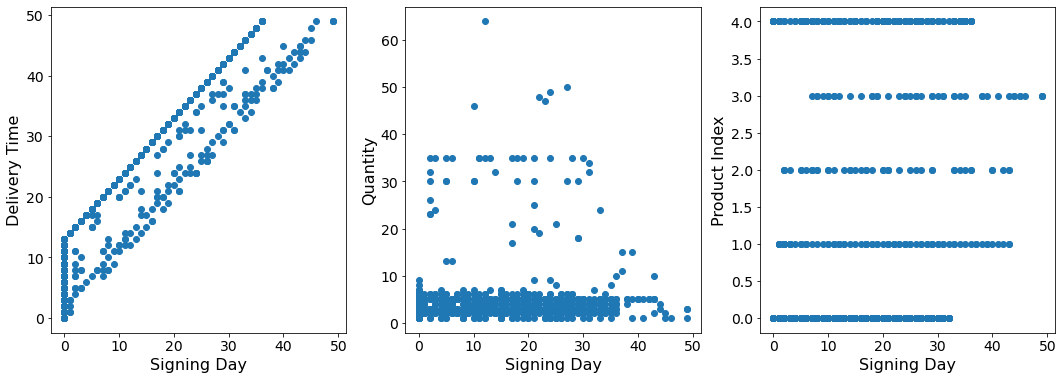

In [30]:
fig, ax = plt.subplots(1, 3)
for i, x in enumerate(["delivery_time", "quantity", "product_index"]):
    ax[i].scatter(signed.signed_at, signed[x])
    ax[i].set(ylabel=x.replace("_", " ").title(), xlabel="Signing Day")
fig.show()

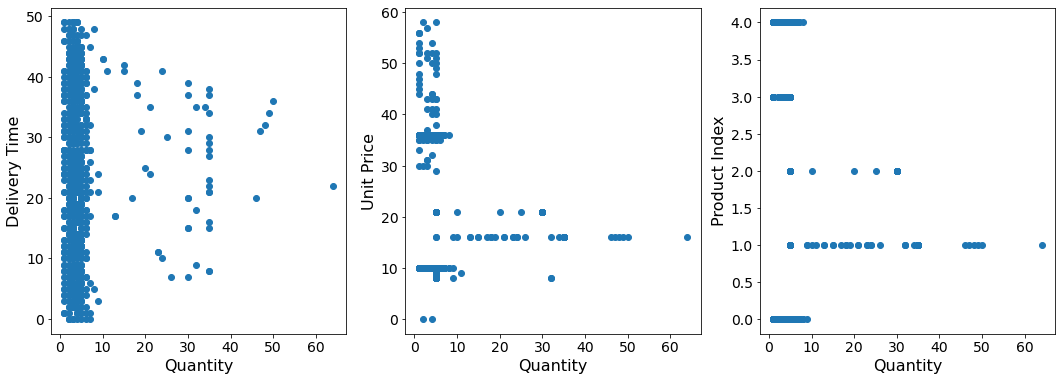

In [31]:
fig, ax = plt.subplots(1, 3)
for i, x in enumerate(["delivery_time", "unit_price", "product_index"]):
    ax[i].scatter(signed.quantity, signed[x])
    ax[i].set(ylabel=x.replace("_", " ").title(), xlabel="Quantity")
fig.show()

Did any agents go bankrupt and when?

In [32]:
bankruptcy = {a: np.nonzero(stats[f"bankrupt_{a}"].values)[0]
        for a in world.non_system_agent_names}
pprint({k: "No" if len(v)<1 else f"at: {v[0]}" for k, v in bankruptcy.items()})

{'00MAD@0': 'No',
 '01BCS@0': 'at: 43',
 '02InD@0': 'No',
 '03Dec@1': 'No',
 '04Dec@1': 'No',
 '05MAI@1': 'No',
 '06MAD@2': 'No',
 '07Dec@2': 'No',
 '08Dec@2': 'No',
 '09SRO@3': 'No',
 '10MoR@3': 'No',
 '11MAI@3': 'No'}


You can see what happened during this simulation by drawing graphs at different steps.
The meaning of different edge colors can be drawn as follows:

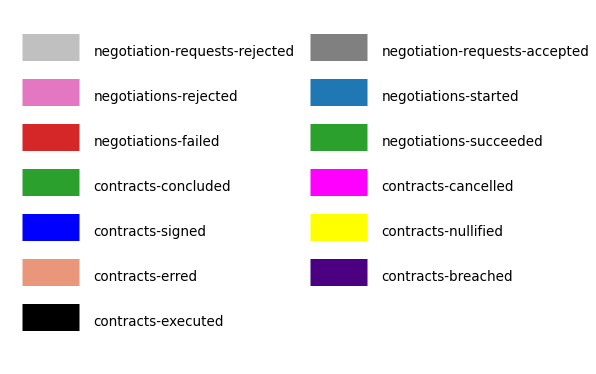

In [33]:
from negmas import show_edge_colors
show_edge_colors()

You can see what happened in this world in a series of graphs using the `draw` method

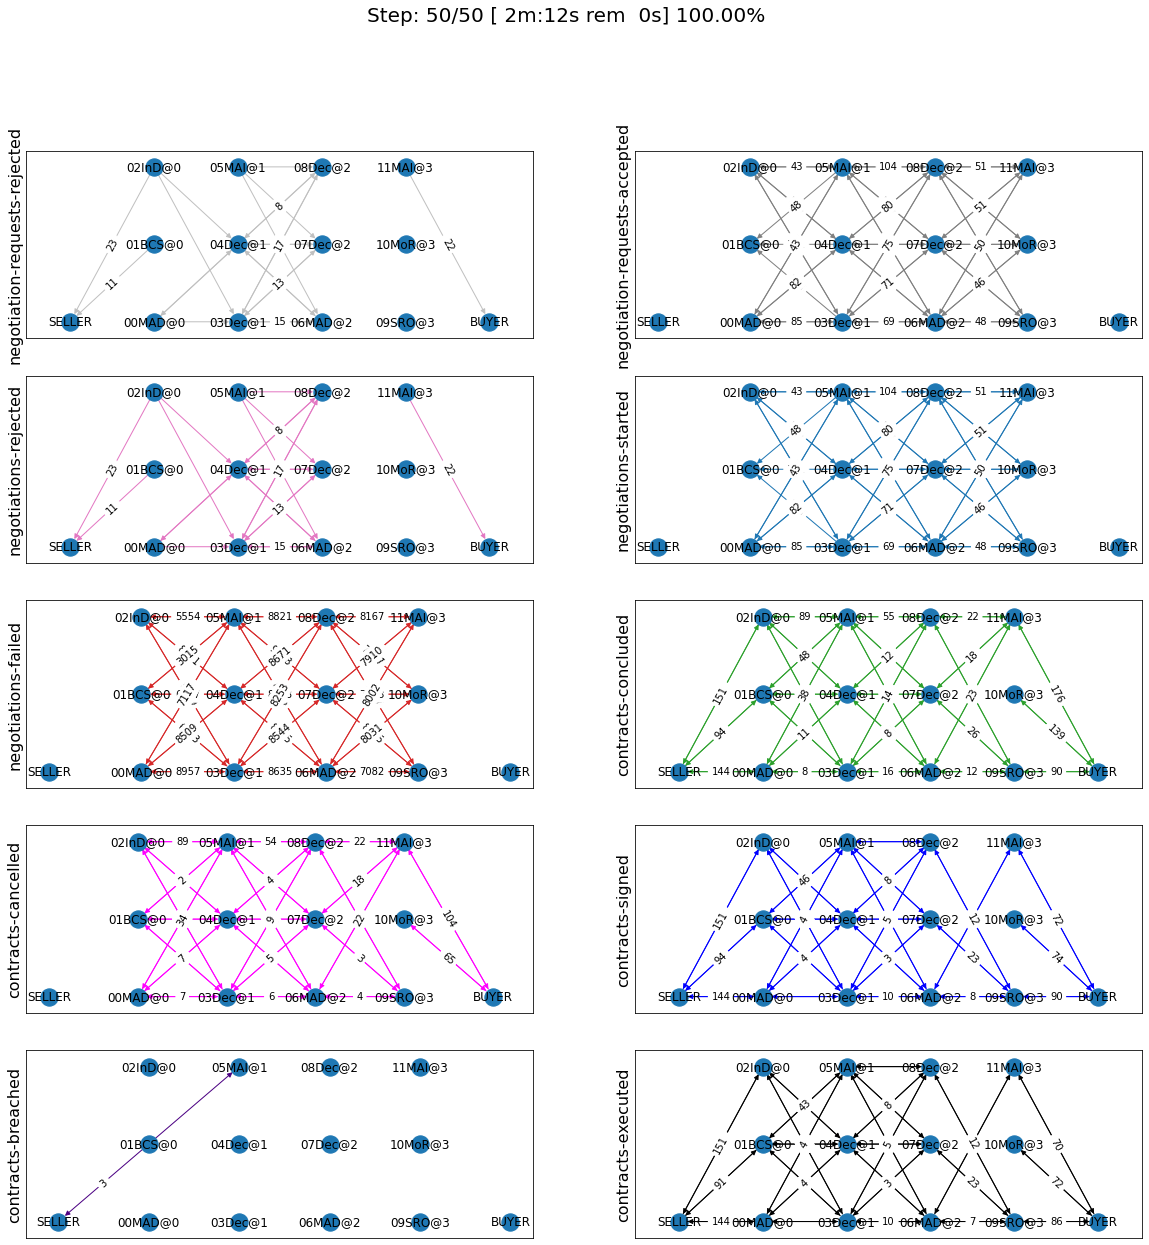

In [34]:
world.draw(steps=(0, world.n_steps), together=False, ncols=2, figsize=(20, 20))
plt.show()

You can also run a simple animation to see what happens at every step (you need to download the jupyter notebook and execute it to see the animation) :

In [35]:
world.save_gif("run.gif")

[]

then show the animation

In [36]:
from IPython.display import HTML
HTML('<img src="run.gif">')

## Running a tournament
    
Now that you can run simple world simulations, let's try to run a complete tournament and see its results.
Let's start by running a standard tournament (in which each agent is represented by a single factory). Running a collusion tournament will be exactly the same with the only difference that `anac2021_std` will be replaced with `anac2021_collusion`.Running a one-shot tournament (new in 2021) similarily just requires a change from `anac2021_std` to `anac2021_oneshot`

Note that in the real competition we use thousands of configurations  and longer simulation steps (e.g. 50 $\le$ n_steps $\le$ 500). 

In [37]:
from scml.scml2020.utils import anac2021_std

In [38]:
tournament_types = agent_types
# may take a long time
results = anac2021_std(
    competitors=tournament_types,  
    n_configs=12, # number of different configurations to generate 
    n_runs_per_world=1, # number of times to repeat every simulation (with agent assignment)
    n_steps = 10, # number of days (simulation steps) per simulation
    print_exceptions=True,
) 

Who was the winner?

In [39]:
results.winners

['scml.scml2020.agents.moving.MovingRangeAgent']

How many simulations were actually run?

In [40]:
len(results.scores.run_id.unique())

504

The total number of simulations $n_{s}$ will be $n_t \times n_c \times n_r$ where $n_t$ is the number of competitor agent types, $n_c$ is the number of configurations, and $n_r$ is the number of runs per configuration


We can also see the scores that every agent type got

In [41]:
results.score_stats

,agent_type,count,mean,std,min,25%,50%,75%,max
0,scml.oneshot.agents.random.SyncRandomOneShotAg...,144.0,-0.275894,0.192558,-1.432894,-0.348131,-0.221367,-0.161451,0.000000
1,scml.scml2020.agents.bcse.BuyCheapSellExpensiv...,144.0,-0.125118,0.117475,-0.451733,-0.192947,-0.095487,-0.021723,0.000000
2,scml.scml2020.agents.decentralizing.Decentrali...,144.0,-0.070443,0.063254,-0.309246,-0.117045,-0.061375,-0.027371,0.149672
3,scml.scml2020.agents.decentralizing.IndDecentr...,144.0,-0.055235,0.106154,-0.394226,-0.105427,-0.043964,-0.003384,0.406353
4,scml.scml2020.agents.decentralizing.MarketAwar...,144.0,-0.070277,0.063758,-0.317073,-0.102820,-0.062338,-0.023626,0.047822
5,scml.scml2020.agents.decentralizing.MarketAwar...,144.0,-0.046381,0.109369,-0.378284,-0.093123,-0.037447,-0.003314,0.362404
6,scml.scml2020.agents.moving.MovingRangeAgent,144.0,-0.076086,0.090697,-0.404901,-0.138729,-0.011931,0.000000,0.000000


You can also do statistical significance testing using ttest or kstest (with multi-comparison correction)

In [42]:
results.kstest

,a,b,t,p,n_a,n_b,n_effective
0,scml.scml2020.agents.decentralizing.Decentrali...,scml.scml2020.agents.moving.MovingRangeAgent,0.409722,3.364550e-11,144,144,144
1,scml.scml2020.agents.decentralizing.Decentrali...,scml.scml2020.agents.decentralizing.MarketAwar...,0.076389,7.966962e-01,144,144,144
2,scml.scml2020.agents.decentralizing.Decentrali...,scml.oneshot.agents.random.SyncRandomOneShotAg...,0.708333,5.172319e-35,144,144,144
3,scml.scml2020.agents.decentralizing.Decentrali...,scml.scml2020.agents.bcse.BuyCheapSellExpensiv...,0.312500,1.295753e-06,144,144,144
4,scml.scml2020.agents.decentralizing.Decentrali...,scml.scml2020.agents.decentralizing.IndDecentr...,0.180556,1.812233e-02,144,144,144
5,scml.scml2020.agents.decentralizing.Decentrali...,scml.scml2020.agents.decentralizing.MarketAwar...,0.180556,1.812233e-02,144,144,144
6,scml.scml2020.agents.moving.MovingRangeAgent,scml.scml2020.agents.decentralizing.MarketAwar...,0.388889,4.211822e-10,144,144,144
7,scml.scml2020.agents.moving.MovingRangeAgent,scml.oneshot.agents.random.SyncRandomOneShotAg...,0.611111,2.084062e-25,144,144,144
8,scml.scml2020.agents.moving.MovingRangeAgent,scml.scml2020.agents.bcse.BuyCheapSellExpensiv...,0.284722,1.509168e-05,144,144,144
9,scml.scml2020.agents.moving.MovingRangeAgent,scml.scml2020.agents.decentralizing.IndDecentr...,0.263889,8.121750e-05,144,144,144


see the total score

In [43]:
results.total_scores

,agent_type,score
0,scml.scml2020.agents.moving.MovingRangeAgent,-0.011931
1,scml.scml2020.agents.decentralizing.MarketAwar...,-0.037447
2,scml.scml2020.agents.decentralizing.IndDecentr...,-0.043964
3,scml.scml2020.agents.decentralizing.Decentrali...,-0.061375
4,scml.scml2020.agents.decentralizing.MarketAwar...,-0.062338
5,scml.scml2020.agents.bcse.BuyCheapSellExpensiv...,-0.095487
6,scml.oneshot.agents.random.SyncRandomOneShotAg...,-0.221367


or the aggregated statistics of the world. For example, let's draw the activity level for different simulations.

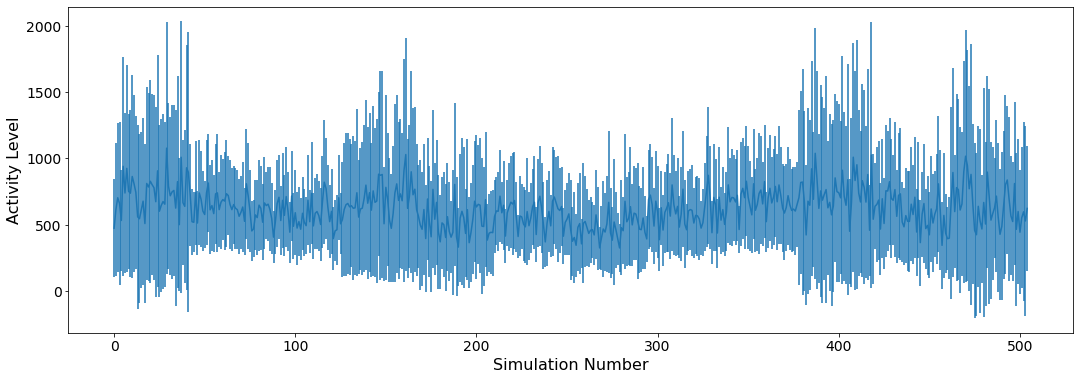

In [44]:
plt.errorbar(range(len(results.agg_stats)),
             results.agg_stats.activity_level_mean, 
             np.sqrt(results.agg_stats.activity_level_var)
             )
plt.xlabel("Simulation Number")
plt.ylabel("Activity Level")
plt.show()

We can even get the scores of every agent belonging to every agent type at every simulation

In [45]:
results.scores.loc[:, ["agent_name", "agent_type", "score"]].head()

,agent_name,agent_type,score
0,08Dec@4,scml.scml2020.agents.decentralizing.Decentrali...,-0.116222
1,09MoR@4,scml.scml2020.agents.moving.MovingRangeAgent,-0.049272
2,08MAD@4,scml.scml2020.agents.decentralizing.MarketAwar...,-0.063281
3,09MoR@4,scml.scml2020.agents.moving.MovingRangeAgent,-0.138139
4,02MoR@1,scml.scml2020.agents.moving.MovingRangeAgent,0.000000


Let's see how did the location at the production graph affect the score of each type.

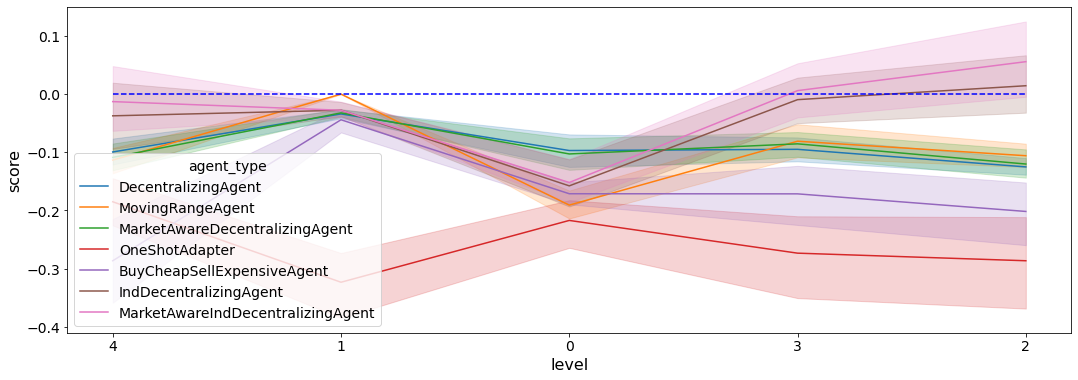

In [46]:
results.scores["level"] = results.scores.agent_name.str.split("@", expand=True).loc[:, 1]
results.scores.agent_type = results.scores.agent_type.str.split(".").str[-1]
sns.lineplot(data=results.scores[["agent_type", "level", "score"]], 
             x="level", y="score", hue="agent_type")
plt.plot([0.0] * len(results.scores["level"].unique()), "b--")
plt.show()

## Running a One-Shot tournament
    
In 2021, a new track was introduced to the SCM league called the SCML-OneShot track which simplified the problem in order to focus research efforts on the core many-to-many concurrent negotiation challeng. You can run a tournament for this league in almost the same way as we did with standard/collusion tournaments using `anac2021_oneshot`

Note that in the real competition we use thousands of configurations  and longer simulation steps (e.g. 50 $\le$ n_steps $\le$ 500). 

In [47]:
from scml.scml2020.utils import anac2021_oneshot

In [48]:
tournament_types = [RandomOneShotAgent, SyncRandomOneShotAgent, GreedyOneShotAgent, GreedySingleAgreementAgent]
# may take a long time
results = anac2021_oneshot(
    competitors=tournament_types,  
    n_configs=12, # number of different configurations to generate 
    n_runs_per_world=1, # number of times to repeat every simulation (with agent assignment)
    n_steps = 10, # number of days (simulation steps) per simulation
    print_exceptions=True,
) 

Who was the winner?

In [49]:
# just make names easier to read 
def short_type(s):
    return s.split(":")[0].split(".")[-1]
    
results.scores.agent_type = results.scores.agent_type.apply(short_type)

How many simulations were actually run?

In [50]:
len(results.scores.run_id.unique())

144

The total number of simulations $n_{s}$ will be $n_t \times n_c \times n_r$ where $n_t$ is the number of competitor agent types, $n_c$ is the number of configurations, and $n_r$ is the number of runs per configuration


We can also see the scores that every agent type got

In [51]:
results.score_stats

,agent_type,count,mean,std,min,25%,50%,75%,max
0,scml.oneshot.agents.greedy.GreedyOneShotAgent:...,72.0,0.893458,0.170055,0.339852,0.781702,1.000000,1.000000,1.000000
1,scml.oneshot.agents.greedy.GreedySingleAgreeme...,72.0,0.888288,0.189036,0.168013,0.764195,1.000000,1.000000,1.000000
2,scml.oneshot.agents.random.RandomOneShotAgent:...,72.0,0.320648,0.443381,-0.766832,0.060918,0.377691,0.705431,0.956150
3,scml.oneshot.agents.random.SyncRandomOneShotAg...,72.0,0.335984,0.443508,-0.999020,0.045306,0.398905,0.718337,1.004897


You can also do statistical significance testing using ttest or kstest (with multi-comparison correction)

In [52]:
results.kstest

,a,b,t,p,n_a,n_b,n_effective
0,scml.oneshot.agents.greedy.GreedySingleAgreeme...,scml.oneshot.agents.greedy.GreedyOneShotAgent:...,0.041667,1.000000e+00,72,72,72
1,scml.oneshot.agents.greedy.GreedySingleAgreeme...,scml.oneshot.agents.random.SyncRandomOneShotAg...,0.694444,6.756412e-17,72,72,72
2,scml.oneshot.agents.greedy.GreedySingleAgreeme...,scml.oneshot.agents.random.RandomOneShotAgent:...,0.708333,1.208464e-17,72,72,72
3,scml.oneshot.agents.greedy.GreedyOneShotAgent:...,scml.oneshot.agents.random.SyncRandomOneShotAg...,0.694444,6.756412e-17,72,72,72
4,scml.oneshot.agents.greedy.GreedyOneShotAgent:...,scml.oneshot.agents.random.RandomOneShotAgent:...,0.694444,6.756412e-17,72,72,72
5,scml.oneshot.agents.random.SyncRandomOneShotAg...,scml.oneshot.agents.random.RandomOneShotAgent:...,0.083333,9.658981e-01,72,72,72


see the total score

In [53]:
results.total_scores

,agent_type,score
0,scml.oneshot.agents.greedy.GreedyOneShotAgent:...,1.000000
1,scml.oneshot.agents.greedy.GreedySingleAgreeme...,1.000000
2,scml.oneshot.agents.random.SyncRandomOneShotAg...,0.398905
3,scml.oneshot.agents.random.RandomOneShotAgent:...,0.377691


We can even get the scores of every agent belonging to every agent type at every simulation

In [54]:
results.scores.loc[:, ["agent_name", "agent_type", "score"]].head()

,agent_name,agent_type,score
0,04GSA@1,GreedySingleAgreementAgent,1.0
1,05Gre@1,GreedyOneShotAgent,1.0
2,04Gre@1,GreedyOneShotAgent,1.0
3,05GSA@1,GreedySingleAgreementAgent,1.0
4,04GSA@1,GreedySingleAgreementAgent,1.0


Let's see how did the location at the production graph affect the score of each type.

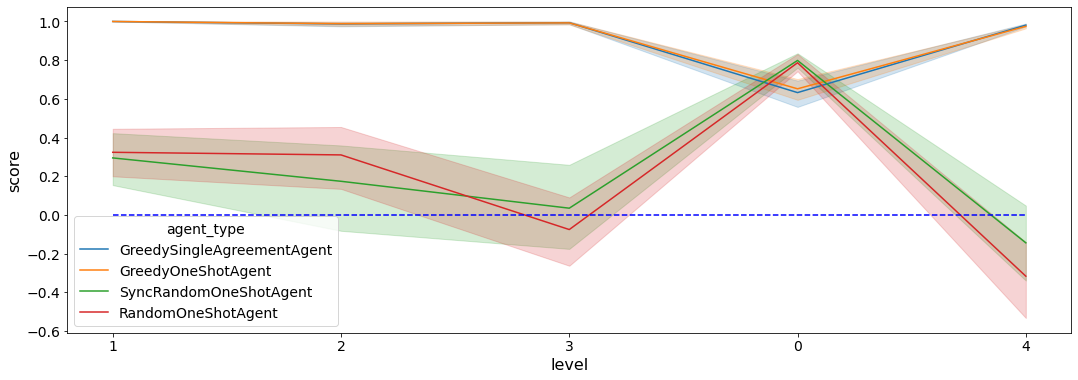

In [55]:
results.scores["level"] = results.scores.agent_name.str.split("@", expand=True).loc[:, 1]
results.scores.agent_type = results.scores.agent_type.str.split(".").str[-1]
sns.lineplot(data=results.scores[["agent_type", "level", "score"]], 
             x="level", y="score", hue="agent_type")
plt.plot([0.0] * len(results.scores["level"].unique()), "b--")
plt.show()

Now that you can run simulations and complete tournament, let's see how are we going to develop a new agent for the SCML2021 league $\rightarrow$